In [2]:
import numpy as np
from scipy.ndimage import shift, rotate, affine_transform, map_coordinates, gaussian_filter

def shift_image(image, dx, dy):
    # dx: +right / -left, dy: +down / -up
    im = image.reshape(28, 28)
    return shift(im, shift=[dy, dx], mode="constant", cval=0.0, order=1).ravel()

def rotate_image(image, degrees):
    # degrees: positive = counter-clockwise
    im = image.reshape(28, 28)
    return rotate(im, angle=degrees, reshape=False, mode="constant", cval=0.0, order=1).ravel()

def scale_image(image, scale):
    # isotropic scaling around center; keep canvas 28x28
    im = image.reshape(28, 28)
    # affine matrix for scaling: output[x, y] = input[(x-cx)/s+cx, (y-cy)/s+cy]
    s = float(scale)
    cx = cy = 13.5
    M = np.array([[1/s, 0, cx - cx/s],
                  [0, 1/s, cy - cy/s],
                  [0,   0,        1 ]])[:2, :3]
    return affine_transform(im, matrix=M[:, :2], offset=M[:,2], output_shape=(28,28),
                            order=1, mode="constant", cval=0.0).ravel()

def shear_image(image, shear_x=0.0, shear_y=0.0):
    # small shear (±0.1–0.2). Matrix maps output coords to input coords.
    im = image.reshape(28, 28)
    cx = cy = 13.5
    Sh = np.array([[1, -shear_x, 0],
                   [-shear_y, 1, 0],
                   [0, 0, 1]])
    # center the transform
    T1 = np.array([[1,0,-cx],[0,1,-cy],[0,0,1]])
    T2 = np.array([[1,0,cx],[0,1,cy],[0,0,1]])
    A = (T2 @ Sh @ T1)[:2, :]
    return affine_transform(im, matrix=A[:,:2], offset=A[:,2], output_shape=(28,28),
                            order=1, mode="constant", cval=0.0).ravel()

def elastic_deform(image, alpha=34, sigma=4):
    """
    Classic elastic deformation:
    - alpha controls intensity (displacement magnitude)
    - sigma controls smoothness (Gaussian filter std)
    Values above are conservative for MNIST 28x28.
    """
    im = image.reshape(28, 28)
    rng = np.random.default_rng()
    dx = gaussian_filter(rng.standard_normal(im.shape), sigma, mode="reflect") * alpha
    dy = gaussian_filter(rng.standard_normal(im.shape), sigma, mode="reflect") * alpha
    x, y = np.meshgrid(np.arange(28), np.arange(28), indexing='xy')
    coords = np.vstack([ (y + dy).ravel(), (x + dx).ravel() ])
    deformed = map_coordinates(im, coords, order=1, mode="constant", cval=0.0).reshape(28, 28)
    return deformed.ravel()


In [6]:
def augment_batch(X, y, max_aug_per_image=2, rng=None):
    rng = np.random.default_rng() if rng is None else rng
    X_aug, y_aug = [X], [y]
    for img, label in zip(X, y):
        k = rng.integers(1, max_aug_per_image+1)
        for _ in range(k):
            op = rng.choice(["shift","rot","shear","elastic"], p=[0.4,0.3,0.2,0.1])
            if op == "shift":
                dx, dy = rng.choice([-1, 1]), 0
                if rng.random() < 0.5: dx, dy = 0, rng.choice([-1, 1])
                aug = shift_image(img, dx, dy)
            elif op == "rot":
                deg = rng.choice([-10, -7, 7, 10])
                aug = rotate_image(img, deg)
            elif op == "shear":
                sx = rng.uniform(-0.12, 0.12)
                aug = shear_image(img, shear_x=sx)
            else:  # elastic (rarer)
                aug = elastic_deform(img, alpha=34, sigma=4)
            X_aug.append(aug); y_aug.append(label)
    return np.concatenate(X_aug), np.concatenate(y_aug)


In [7]:
# Full MNIST pipeline: fetch → tune → baseline → augment → final train → evaluate
# ---------------------------------------------------------
# Notes:
# - We use conservative augmentations (±1 px shifts) that reflect natural handwriting variation.
# - HalvingGridSearchCV (successive halving) gives efficient hyperparam tuning.
# - KNN benefits from augmentation but gets slower as the dataset grows; adjust the subset sizes if needed.

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Enable successive halving search
from sklearn.experimental import enable_halving_search_cv  # noqa: F401
from sklearn.model_selection import HalvingGridSearchCV

# -----------------------------
# 1) Fetch & prepare MNIST
# -----------------------------
mnist = fetch_openml("mnist_784", version=1, as_frame=False)
X, y = mnist["data"], mnist["target"].astype(np.uint8)

# Normalize pixel intensities to [0,1] (KNN distance benefits from uniform scale)
X = X.astype(np.float32) / 255.0

# Standard split: 60k train, 10k test (stratified to preserve class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=10_000, stratify=y, random_state=42
)

# -----------------------------
# 2) Utilities: shift augmentation
# -----------------------------
from scipy.ndimage import shift

def shift_image(image, dx, dy):
    """
    Shift a 28x28 image by (dx, dy) with zero-fill (black background).
    dx: +right / -left
    dy: +down  / -up
    """
    im = image.reshape(28, 28)
    shifted = shift(im, shift=[dy, dx], mode="constant", cval=0.0, order=1)
    return shifted.ravel()

def augment_four_translations(X_arr, y_arr):
    """For each image, create four shifted copies: left, right, up, down by 1 px."""
    X_aug = [X_arr]
    y_aug = [y_arr]
    for dx, dy in ((-1, 0), (1, 0), (0, 1), (0, -1)):
        shifted_block = np.vstack([shift_image(img, dx, dy) for img in X_arr])
        X_aug.append(shifted_block)
        y_aug.append(y_arr)
    X_out = np.concatenate(X_aug, axis=0)
    y_out = np.concatenate(y_aug, axis=0)

    # Shuffle to avoid block structure
    idx = np.random.default_rng(123).permutation(len(X_out))
    return X_out[idx], y_out[idx]

# -----------------------------
# 3) Hyperparameter tuning (successive halving on a subset)
# -----------------------------
# You can increase 'tune_n' to use more data for tuning (tradeoff: time).
tune_n = 20_000
rng = np.random.default_rng(123)
subset_idx = rng.choice(len(X_train), size=tune_n, replace=False)
X_tune, y_tune = X_train[subset_idx], y_train[subset_idx]

param_grid = {
    "n_neighbors": [3, 4, 5, 6, 7, 9],
    "weights": ["uniform", "distance"],
    "p": [1, 2],            # 1=Manhattan, 2=Euclidean
    "leaf_size": [15, 30],  # small effect, but can matter for speed
}

base_estimator = KNeighborsClassifier(n_jobs=-1)
halving = HalvingGridSearchCV(
    base_estimator,
    param_grid=param_grid,
    factor=2,            # how aggressively to halve
    resource="n_samples",
    max_resources=tune_n,
    scoring="accuracy",
    cv=3,
    n_jobs=-1,
    verbose=1,
    refit=True,
    random_state=123,
)

halving.fit(X_tune, y_tune)
best_params = halving.best_params_
print("Best params (tuning subset):", best_params)

# -----------------------------
# 4) Baseline: train on original X_train with tuned params
# -----------------------------
knn_baseline = KNeighborsClassifier(**best_params, n_jobs=-1)
knn_baseline.fit(X_train, y_train)
baseline_acc = accuracy_score(y_test, knn_baseline.predict(X_test))
print(f"Baseline test accuracy (no augmentation): {baseline_acc:.4f}")

# -----------------------------
# 5) Augment training set (±1 px shifts), retrain & evaluate
# -----------------------------
X_train_aug, y_train_aug = augment_four_translations(X_train, y_train)

knn_aug = KNeighborsClassifier(**best_params, n_jobs=-1)
knn_aug.fit(X_train_aug, y_train_aug)
aug_acc = accuracy_score(y_test, knn_aug.predict(X_test))
print(f"Augmented test accuracy: {aug_acc:.4f}")

# -----------------------------
# 6) Comparative report
# -----------------------------
baseline_err = 1.0 - baseline_acc
aug_err = 1.0 - aug_acc
if baseline_err > 0:
    err_rate_change = (aug_err / baseline_err) - 1.0
else:
    err_rate_change = 0.0

print(f"Error-rate change vs baseline: {err_rate_change:.0%}")
print("↓ A negative value indicates the augmented model reduced the error rate (a salutary improvement).")

# -----------------------------
# (Optional) Quick sanity visual on a few augmentations
# -----------------------------
def demo_augment(n=6):
    sample = X_train[:n]
    titles = ["orig", "left", "right", "down", "up"]
    figs = []
    for i in range(n):
        variants = [
            sample[i].reshape(28,28),
            shift_image(sample[i], -1, 0).reshape(28,28),
            shift_image(sample[i],  1, 0).reshape(28,28),
            shift_image(sample[i],  0, 1).reshape(28,28),
            shift_image(sample[i],  0,-1).reshape(28,28),
        ]
        figs.append(variants)
    plt.figure(figsize=(10, 2*n))
    for r, row in enumerate(figs):
        for c, im in enumerate(row):
            ax = plt.subplot(n, 5, r*5+c+1)
            ax.imshow(im, cmap="Greys", interpolation="nearest")
            ax.axis("off")
            if r == 0:
                ax.set_title(titles[c], fontsize=9)
    plt.tight_layout()
    plt.show()

# demo_augment()  # uncomment to preview


/Users/cphoward/Development/cphoward/handson-ml3/.venv/lib/python3.10/site-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


n_iterations: 6
n_required_iterations: 6
n_possible_iterations: 6
min_resources_: 625
max_resources_: 20000
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 48
n_resources: 625
Fitting 3 folds for each of 48 candidates, totalling 144 fits
----------
iter: 1
n_candidates: 24
n_resources: 1250
Fitting 3 folds for each of 24 candidates, totalling 72 fits
----------
iter: 2
n_candidates: 12
n_resources: 2500
Fitting 3 folds for each of 12 candidates, totalling 36 fits
----------
iter: 3
n_candidates: 6
n_resources: 5000
Fitting 3 folds for each of 6 candidates, totalling 18 fits
----------
iter: 4
n_candidates: 3
n_resources: 10000
Fitting 3 folds for each of 3 candidates, totalling 9 fits
----------
iter: 5
n_candidates: 2
n_resources: 20000
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best params (tuning subset): {'leaf_size': 30, 'n_neighbors': 4, 'p': 2, 'weights': 'distance'}
Baseline test accuracy (no augmentation): 0.9759
Augmented test accuracy

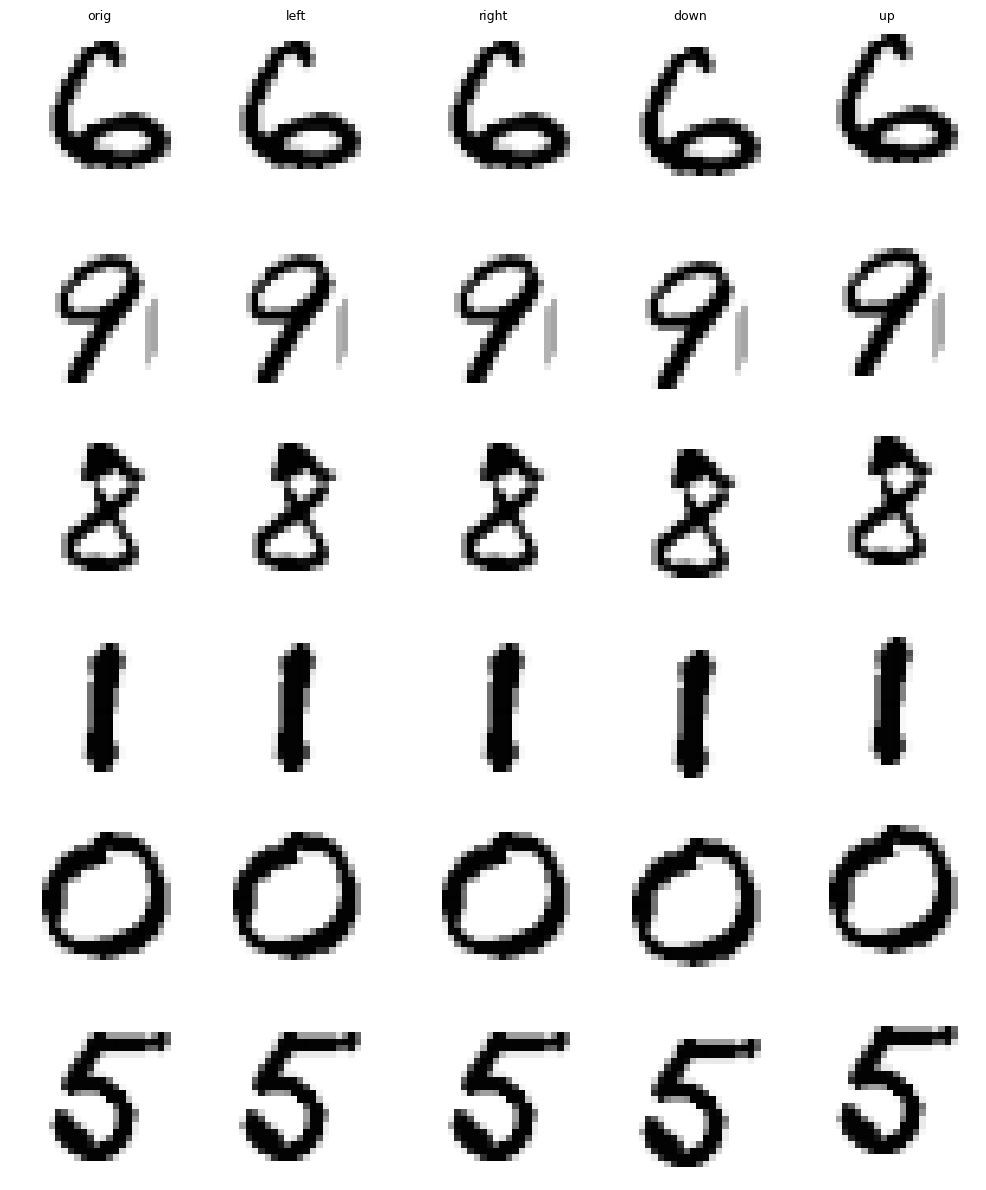

In [9]:
demo_augment()

In [10]:
# =========================================================
# Experiment: randomized augment_batch vs four-shift vs none
# =========================================================

import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

# If best_params or baseline_acc don’t exist (fresh kernel), tune quickly & compute baseline.
try:
    _ = best_params
except NameError:
    from sklearn.experimental import enable_halving_search_cv  # noqa: F401
    from sklearn.model_selection import HalvingGridSearchCV

    # Quick tune on a subset to keep things brisk.
    tune_n = min(20_000, len(X_train))
    rng_tune = np.random.default_rng(123)
    subset_idx = rng_tune.choice(len(X_train), size=tune_n, replace=False)
    X_tune, y_tune = X_train[subset_idx], y_train[subset_idx]

    param_grid = {
        "n_neighbors": [3, 4, 5, 6, 7, 9],
        "weights": ["uniform", "distance"],
        "p": [1, 2],
        "leaf_size": [15, 30],
    }
    halving = HalvingGridSearchCV(
        KNeighborsClassifier(n_jobs=-1),
        param_grid=param_grid,
        factor=2,
        resource="n_samples",
        max_resources=tune_n,
        scoring="accuracy",
        cv=3,
        n_jobs=-1,
        verbose=1,
        random_state=123,
        refit=True,
    )
    halving.fit(X_tune, y_tune)
    best_params = halving.best_params_
    print("Best params (auto-tuned in this block):", best_params)

# --- Transform primitives (conservative) ---
from scipy.ndimage import shift, rotate, affine_transform, map_coordinates, gaussian_filter

def shift_image(image, dx, dy):
    im = image.reshape(28, 28)
    return shift(im, [dy, dx], mode="constant", cval=0.0, order=1).ravel()

def rotate_image(image, degrees):
    im = image.reshape(28, 28)
    return rotate(im, angle=degrees, reshape=False, mode="constant", cval=0.0, order=1).ravel()

def shear_image(image, shear_x=0.0, shear_y=0.0):
    im = image.reshape(28, 28)
    cx = cy = 13.5
    Sh = np.array([[1, -shear_x, 0],
                   [-shear_y, 1, 0],
                   [0, 0, 1]])
    T1 = np.array([[1,0,-cx],[0,1,-cy],[0,0,1]])
    T2 = np.array([[1,0,cx],[0,1,cy],[0,0,1]])
    A = (T2 @ Sh @ T1)[:2, :]
    return affine_transform(im, matrix=A[:,:2], offset=A[:,2], output_shape=(28,28),
                            order=1, mode="constant", cval=0.0).ravel()

def elastic_deform(image, alpha=34, sigma=4):
    im = image.reshape(28, 28)
    rng = np.random.default_rng()
    dx = gaussian_filter(rng.standard_normal(im.shape), sigma, mode="reflect") * alpha
    dy = gaussian_filter(rng.standard_normal(im.shape), sigma, mode="reflect") * alpha
    x, y = np.meshgrid(np.arange(28), np.arange(28), indexing='xy')
    coords = np.vstack([(y + dy).ravel(), (x + dx).ravel()])
    deformed = map_coordinates(im, coords, order=1, mode="constant", cval=0.0).reshape(28, 28)
    return deformed.ravel()

# --- Deterministic four-shift augmentation (reference) ---
def augment_four_translations(X_arr, y_arr):
    X_aug = [X_arr]; y_aug = [y_arr]
    for dx, dy in ((-1,0),(1,0),(0,1),(0,-1)):
        X_aug.append(np.vstack([shift_image(img, dx, dy) for img in X_arr]))
        y_aug.append(y_arr)
    X_out = np.concatenate(X_aug, axis=0)
    y_out = np.concatenate(y_aug, axis=0)
    idx = np.random.default_rng(123).permutation(len(X_out))
    return X_out[idx], y_out[idx]

# --- Randomized augmentation with multiple ops (your request) ---
def augment_batch(X, y, max_aug_per_image=2, ops=("shift","rot","shear","elastic"),
                  probs=None, rng=None):
    """
    Randomly applies up to max_aug_per_image ops per image.
    - ops: subset of {"shift","rot","shear","elastic"}.
    - probs: selection probabilities matching len(ops). If None, default weights are used.
    """
    rng = np.random.default_rng() if rng is None else rng
    if probs is None:
        # Favor shifts, then small rotations; shears rarer; elastic rarest.
        # Adjust to taste, but keep elastic sparse to avoid artifacts.
        default = {"shift":0.45, "rot":0.30, "shear":0.18, "elastic":0.07}
        probs = np.array([default[o] for o in ops], dtype=float)
        probs = probs / probs.sum()

    X_aug_parts = [X]
    y_aug_parts = [y]

    for img, label in zip(X, y):
        k = rng.integers(1, max_aug_per_image+1)
        for _ in range(k):
            op = rng.choice(ops, p=probs)
            if op == "shift":
                # one-pixel shift, axis chosen at random
                if rng.random() < 0.5:
                    dx, dy = rng.choice([-1, 1]), 0
                else:
                    dx, dy = 0, rng.choice([-1, 1])
                aug = shift_image(img, dx, dy)
            elif op == "rot":
                deg = rng.choice([-10, -7, 7, 10])
                aug = rotate_image(img, deg)
            elif op == "shear":
                sx = rng.uniform(-0.12, 0.12)
                sy = 0.0  # keep vertical shear off by default
                aug = shear_image(img, shear_x=sx, shear_y=sy)
            else:  # elastic
                aug = elastic_deform(img, alpha=34, sigma=4)
            X_aug_parts.append(aug[np.newaxis, :])
            y_aug_parts.append(np.array([label], dtype=y.dtype))

    X_aug = np.concatenate(X_aug_parts, axis=0)
    y_aug = np.concatenate(y_aug_parts, axis=0)

    # Shuffle to dissolve blockiness
    idx = rng.permutation(len(X_aug))
    return X_aug[idx], y_aug[idx]

# --- One-shot runner for a variant ---
def run_variant(name, make_augmented, *, params, report_baseline=None):
    """Train KNN on augmented data returned by make_augmented(), evaluate on test set."""
    X_tr_aug, y_tr_aug = make_augmented()
    print(f"[{name}] Training on {len(X_tr_aug):,} samples (orig {len(X_train):,})...")
    clf = KNeighborsClassifier(**params, n_jobs=-1)
    clf.fit(X_tr_aug, y_tr_aug)
    acc = accuracy_score(y_test, clf.predict(X_test))
    print(f"[{name}] Test accuracy: {acc:.4f}")
    if report_baseline is not None:
        base_acc = report_baseline
        base_err = 1.0 - base_acc
        err = 1.0 - acc
        delta = (err / base_err) - 1.0 if base_err > 0 else 0.0
        print(f"[{name}] Error-rate change vs baseline: {delta:.0%} (negative is better)")
    return acc

# --- Baseline (no augmentation) ---
print("\n== Baseline (no augmentation) ==")
knn_base = KNeighborsClassifier(**best_params, n_jobs=-1)
knn_base.fit(X_train, y_train)
baseline_acc = accuracy_score(y_test, knn_base.predict(X_test))
print(f"[baseline] Test accuracy: {baseline_acc:.4f}")

# --- Variant A: four fixed 1px shifts (reference from earlier) ---
print("\n== Variant A: Four-shift augmentation ==")
X4, y4 = augment_four_translations(X_train, y_train)
acc_four = run_variant(
    "four-shift",
    make_augmented=lambda: (X4, y4),
    params=best_params,
    report_baseline=baseline_acc
)

# --- Variant B: randomized augment_batch (shift+rot+shear+elastic) ---
print("\n== Variant B: augment_batch (shift+rot+shear+elastic) ==")
rng = np.random.default_rng(42)
acc_batch = run_variant(
    "augment_batch: all ops",
    make_augmented=lambda: augment_batch(
        X_train, y_train,
        max_aug_per_image=2,
        ops=("shift","rot","shear","elastic"),
        probs=None,  # use defaults
        rng=rng
    ),
    params=best_params,
    report_baseline=baseline_acc
)

# --- (Optional) Ablations to see which ops pull their weight ---
print("\n== Optional ablations (smaller sets suggested if time is tight) ==")
ablations = [
    ("shift-only", ("shift",)),
    ("shift+rot", ("shift","rot")),
    ("shift+rot+shear", ("shift","rot","shear")),
    ("all+elastic", ("shift","rot","shear","elastic")),
]
abl_results = {}
for label, ops in ablations:
    rng_local = np.random.default_rng(123)
    acc = run_variant(
        f"augment_batch: {label}",
        make_augmented=lambda ops=ops, rng_local=rng_local: augment_batch(
            X_train, y_train,
            max_aug_per_image=2,
            ops=ops,
            probs=None,
            rng=rng_local
        ),
        params=best_params,
        report_baseline=baseline_acc
    )
    abl_results[label] = acc

print("\n== Summary ==")
print(f"Baseline (none):           {baseline_acc:.4f}")
print(f"Four-shift:                {acc_four:.4f}")
print(f"augment_batch (all ops):   {acc_batch:.4f}")
for k, v in abl_results.items():
    print(f"augment_batch {k:>16}: {v:.4f}")



== Baseline (no augmentation) ==
[baseline] Test accuracy: 0.9759

== Variant A: Four-shift augmentation ==
[four-shift] Training on 300,000 samples (orig 60,000)...
[four-shift] Test accuracy: 0.9805
[four-shift] Error-rate change vs baseline: -19% (negative is better)

== Variant B: augment_batch (shift+rot+shear+elastic) ==
[augment_batch: all ops] Training on 150,100 samples (orig 60,000)...
[augment_batch: all ops] Test accuracy: 0.9780
[augment_batch: all ops] Error-rate change vs baseline: -9% (negative is better)

== Optional ablations (smaller sets suggested if time is tight) ==
[augment_batch: shift-only] Training on 150,131 samples (orig 60,000)...
[augment_batch: shift-only] Test accuracy: 0.9772
[augment_batch: shift-only] Error-rate change vs baseline: -5% (negative is better)
[augment_batch: shift+rot] Training on 149,863 samples (orig 60,000)...
[augment_batch: shift+rot] Test accuracy: 0.9773
[augment_batch: shift+rot] Error-rate change vs baseline: -6% (negative is b